# Chapter4: PyMCによるベイズ分析

In [2]:
# 必要なライブラリをインポート
import numpy as np
import scipy.stats as st
import scipy.linalg as la
import pymc3 as pm
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## ベイズ統計学とモンテカルロ法
現実のデータは自然共役事前分布が存在する簡単なモデルだけで説明がつかないことが多い．

### ベイズ統計学を実践する上での問題点
表記を統一（ベクトルは太文字表記していない）
|||
|-|-|
|$\theta$|未知のパラメータ（$m$次元ベクトル）|
|$D$|データ|
|$p(x\|\theta)$|確率分布|
|$p(\theta)$|事前分布|
|$p(D\|\theta )$|尤度|
|$p(\theta \|D)$|事後分布|

このとき，ベイズの定理より
$$
    p(\theta|D) = \frac{p(D|\theta)p(\theta)}{\int_{R^m}p(D|\theta)p(\theta)d\theta},
$$
である．この分母のことを**基準化定数**と呼び，自然共役事前分布が存在する場合は基準化定数を求めることができる．一方で，一般的には多重積分を解析的に求めることができるとは限らない．

### モンテカルロ法
上記の問題点を受けて，多重積分を解析的に求められないのであれば数値的に求めようというする方法が多数提案されている．その1つが**モンテカルロ法**であり，ベイズ統計学における中心的な数値積分法．以下，モンテカルロ法のざっくりとしたイメージ．

ベイズ統計学で使う事後統計量の多くが
$$
    E_{\theta}[h(\theta)] = \int_{R^m}h(\theta)p(\theta|D)d\theta,
$$
という期待値の形をしていることを利用する

e.g: 平均（$E_{\theta}[\theta_j\|D]: h(\theta)=\theta_j$）, 分散（$Var_{\theta}[\theta_j\|D]: h(\theta)=(\theta_j - E_{\theta}[\theta_j\|D])^2$）, etc...

ここで，事後分布$p(\theta\|D)$からパラメータ$\theta$の乱数${\theta^{(1)}, ..., \theta^{(T)}}$を独立に$T$個生成できるとすると
$$
    \hat{h} = \frac{1}{T}\sum_{t=1}^T h(\theta^{t}), 
$$
が計算でき，$T$を十分に大きくすれば，$\hat{h}$によって$E_{\theta}[h(\theta)]$を近似できるという発想（大数の法則的な）

## PyMCによる回帰モデルのベイズ分析
手元にモンテカルロ標本がない（事後分布が何の分布かも分からない）状態で，乱数を生成することを可能にする手法が**マルコフ連鎖サンプリング法**．

これを活用したモンテカルロ法を**マルコフ連鎖モンテカルロ（MCMC: Markov Chain Monte Carlo）法**と呼び，PythonではPyMCを用いることで簡単に実装できる．

### 大まかな手順
関数`pm.Model()`を使って確率モデルのオブジェクトを作成し，下記の流れで事後分布からモンテカルロ標本を生成する．
1. 事前分布を設定
2. 尤度を設定
3. 事後分布からのモンテカルロ標本の生成
    - draw: 生成回数
    - chains: 乱数系列の数
    - tune: 調整用の試行回数（ちょっとよく分からない...）

### 回帰モデルのベイズ分析（自然共役事前分布）
データ
$$
    y_i = 1 + 2x + u_i, \ u_i \sim N(0, 0.49), \ i=1,...,50, 
$$

事前分布
$$
    \beta = \begin{bmatrix}
        \beta_0 \\ \beta_1
    \end{bmatrix}
    \sim
    \bigg(
        \begin{bmatrix}
            0 \\ 0
        \end{bmatrix}, \
        \begin{bmatrix}
            0.2 & 0 \\
            0 & 0.2
        \end{bmatrix}
    \bigg), \ 
    \sigma^2 \sim
    Ga^{-1} \bigg( \frac{5}{2}, \frac{7}{2} \bigg), 
$$

※$\beta$と$\sigma^2$が独立でないケースでは，無理にMCMC法を利用せずとも自然共役事前分布を利用することで事後分布を導出できる

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma2]


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
a       1.000  0.109   0.795    1.205      0.001    0.000   26088.0   14292.0  \
b       2.003  0.113   1.798    2.221      0.001    0.001   24506.0   14727.0   
sigma2  0.588  0.118   0.388    0.811      0.001    0.001   21382.0   13222.0   

        r_hat  
a         1.0  
b         1.0  
sigma2    1.0  


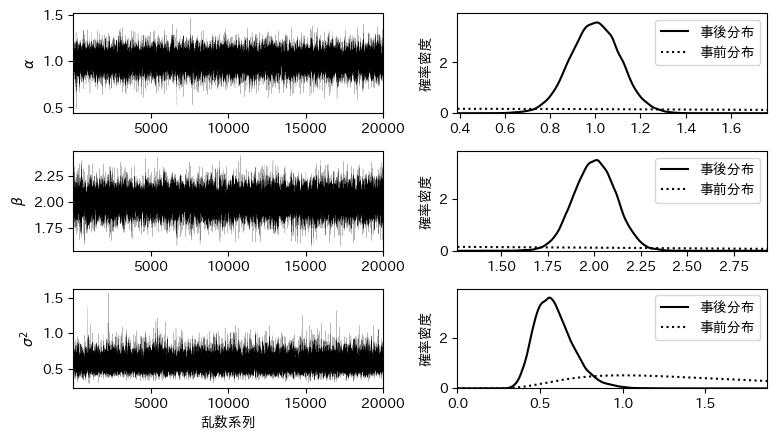

In [2]:
# 4.1: 回帰モデルのベイズ分析（自然共役事前分布）
# 回帰モデルからデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0*x + u

# 回帰モデルの係数と誤差項の分散の事後分布の設定（自然共役事前分布）
b0 = np.zeros(2)
A0 = 0.2 * np.eye(2)
nu0 = 5.0
lam0 = 7.0
h0 = np.sqrt(np.diag(lam0 / nu0 * la.inv(A0)))
sd0 = np.sqrt(np.diag(la.inv(A0)))
regression_conjugate = pm.Model()
with regression_conjugate:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0) #事前分布の設定
    sigma = pm.math.sqrt(sigma2) #事前分布の設定
    a = pm.Normal('a', mu=b0[0], sd=sigma*sd0[0]) #事前分布の設定
    b = pm.Normal('b', mu=b0[1], sd=sigma*sd0[1]) #事前分布の設定
    y_hat = a + b*x #尤度の設定
    likelihood = pm.Normal('y', mu=y_hat, sd=sigma, observed=y) #尤度の設定

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with regression_conjugate:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))

# 事後分布のグラフの作成
k = b0.size
param_names = ['a', 'b', 'sigma2']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma^2$']
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for idx in range(k+1):
    mc_trace = trace[param_names[idx]]
    if idx < k:
        x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=b0[idx], scale=sd0[idx])
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        ax[idx, 0].set_xlabel('乱数系列')
        ax[idx, 1].set_ylabel('パラメータの分布')
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel(labels[idx])
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[idx, 1].plot(x, prior, 'k:', label='事前分布')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
    ax[idx, 1].legend(loc='best')
plt.tight_layout()
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


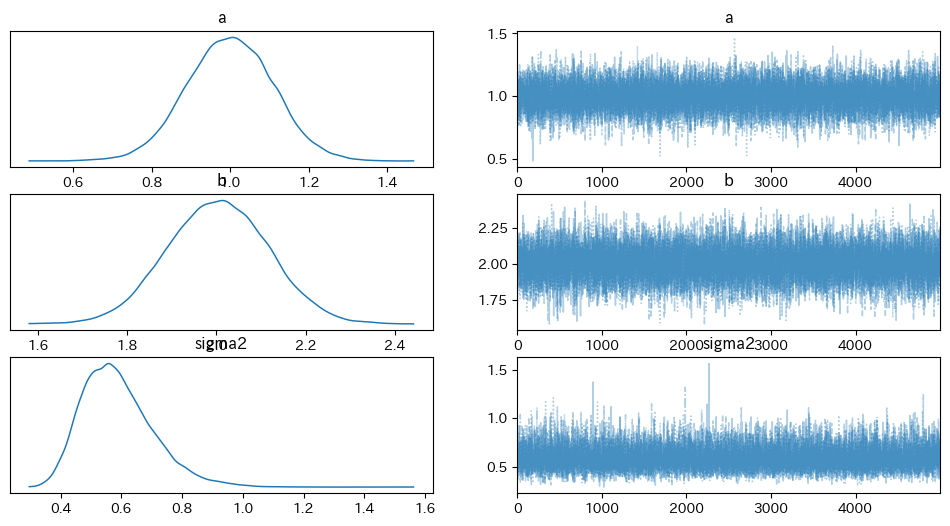

Got error No model on context stack. trying to find log_likelihood in translation.


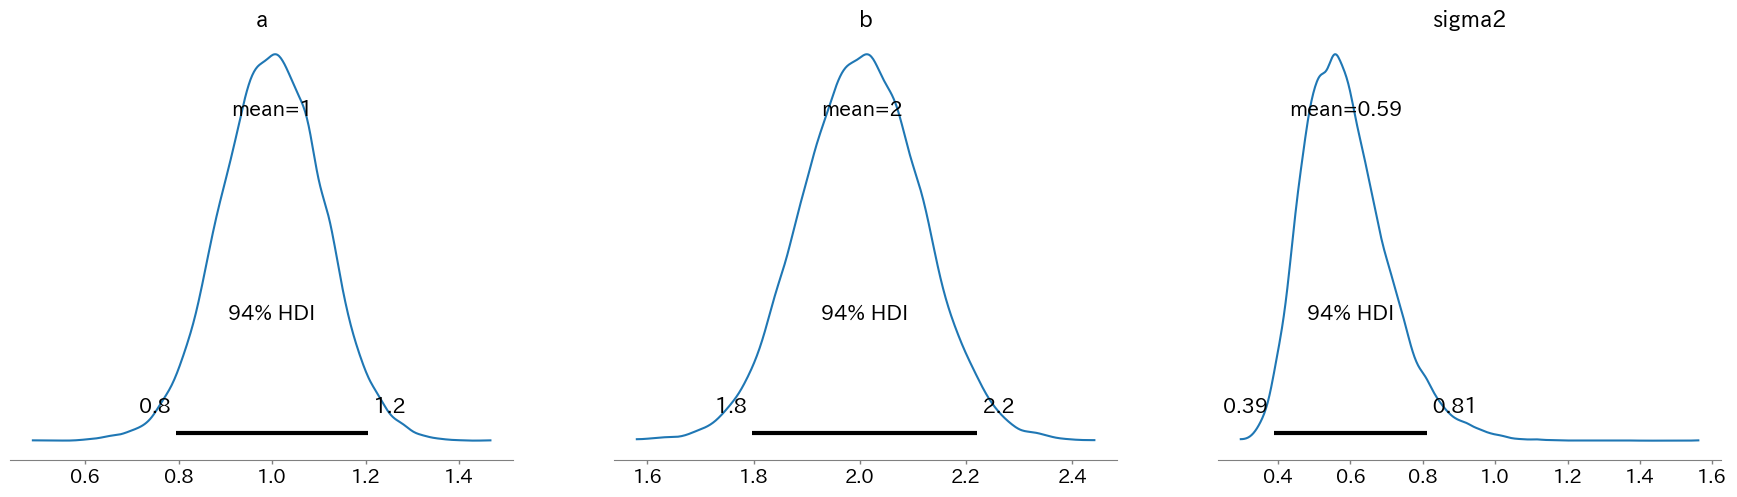

In [7]:
# PyMCには手軽に乱数系列に関する図を作成する関数が用意されている
# カーネル密度推定で求めた周辺事後分布を表示
pm.traceplot(trace, combined=True)
plt.show()

# 周辺事後分布，点推定，HPD区間をまとめて表示
pm.plot_posterior(trace, point_estimate='mean')
plt.show()

### 回帰モデルのベイズ分析（正規分布+逆ガンマ分布）
データ
$$
    y_i = 1 + 2x + u_i, \ u_i \sim N(0, 0.49), \ i=1,...,50, 
$$

事前分布
$$
    \beta = \begin{bmatrix}
        \beta_0 \\ \beta_1
    \end{bmatrix}
    \sim
    N \bigg(
        \begin{bmatrix}
            0 \\ 0
        \end{bmatrix}, \
        \begin{bmatrix}
            0.2 & 0 \\
            0 & 0.2
        \end{bmatrix}
    \bigg), \ 
    \sigma^2 \sim
    Ga^{-1} \bigg( \frac{5}{2}, \frac{7}{2} \bigg), \
    \beta \perp \sigma^2, 
$$

※$\beta \perp \sigma^2$という条件があるため，自然共役事前分布が利用できない

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma2]


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
a       1.000  0.111   0.792    1.209      0.001    0.001   21763.0   13564.0  \
b       2.007  0.113   1.792    2.217      0.001    0.001   24137.0   14051.0   
sigma2  0.591  0.120   0.386    0.815      0.001    0.001   22463.0   13543.0   

        r_hat  
a         1.0  
b         1.0  
sigma2    1.0  


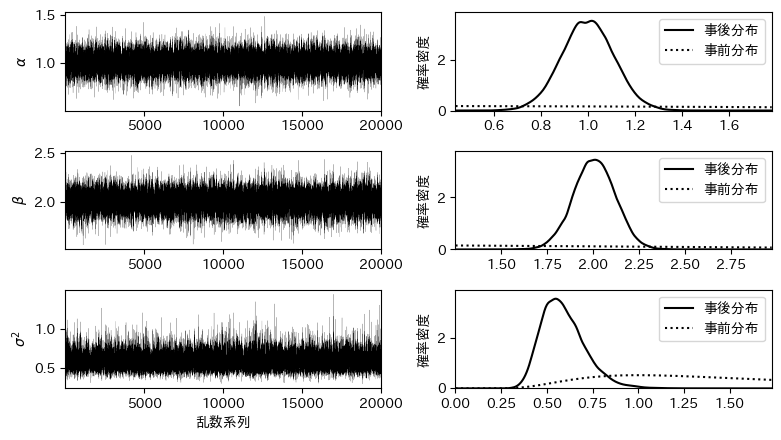

In [8]:
# 4.2 回帰モデルのベイズ分析（正規分布+逆ガンマ分布）
# 回帰モデルからデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0*x + u

# 回帰モデルの係数と誤差項の分散の事後分布の設定（正規分布+逆ガンマ分布）
b0 = np.zeros(2)
A0 = 0.2 * np.eye(2)
nu0 = 5.0
lam0 = 7.0
sd0 = np.sqrt(np.diag(la.inv(A0)))
regression_normal_invgamma = pm.Model()
with regression_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0) #事前分布の設定
    a = pm.Normal('a', mu=0.0, sd=sd0[0]) #事前分布の設定
    b = pm.Normal('b', mu=0.0, sd=sd0[1]) #事前分布の設定
    y_hat = a + b*x #尤度の設定
    likelihood = pm.Normal('y', mu=y_hat, sd=pm.math.sqrt(sigma2), observed=y) #尤度の設定

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with regression_normal_invgamma:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))

# 事後分布のグラフの作成
k = b0.size
param_names = ['a', 'b', 'sigma2']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma^2$']
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for idx in range(k+1):
    mc_trace = trace[param_names[idx]]
    if idx < k:
        x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=b0[idx], scale=sd0[idx])
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        ax[idx, 0].set_xlabel('乱数系列')
        ax[idx, 1].set_ylabel('パラメータの分布')
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel(labels[idx])
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[idx, 1].plot(x, prior, 'k:', label='事前分布')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
    ax[idx, 1].legend(loc='best')
plt.tight_layout()
plt.show()

### 回帰モデルのベイズ分析（重回帰モデル）
データ
$$
    y_i = 1 + 2x_{1i} - x_{2i} + u_i, \ u_i \sim N(0, 0.49), \ i=1,...,50, 
$$

事前分布
$$
    \begin{bmatrix}
        \beta_1 \\
        \beta_2 \\
        \beta_3
    \end{bmatrix}
    \sim
    N \Bigg(
        \begin{bmatrix}
            0 \\ 
            0 \\ 
            0
        \end{bmatrix}, \
        \begin{bmatrix}
            0.2 & 0 & 0 \\
            0 & 0.2 & 0 \\
            0 & 0 & 0.2
        \end{bmatrix}^{-1}
    \Bigg), \ 
    \sigma^2 \sim Ga^{-1} \bigg(
        \frac{5}{2}, \ \frac{7}{2}
    \bigg), 
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma2]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
b[0]    0.975  0.111   0.765    1.183      0.001    0.000   26531.0   15960.0  \
b[1]    2.022  0.113   1.818    2.242      0.001    0.001   25621.0   15935.0   
b[2]   -0.868  0.115  -1.079   -0.650      0.001    0.000   26953.0   16126.0   
sigma2  0.587  0.120   0.377    0.806      0.001    0.001   23981.0   14125.0   

        r_hat  
b[0]      1.0  
b[1]      1.0  
b[2]      1.0  
sigma2    1.0  


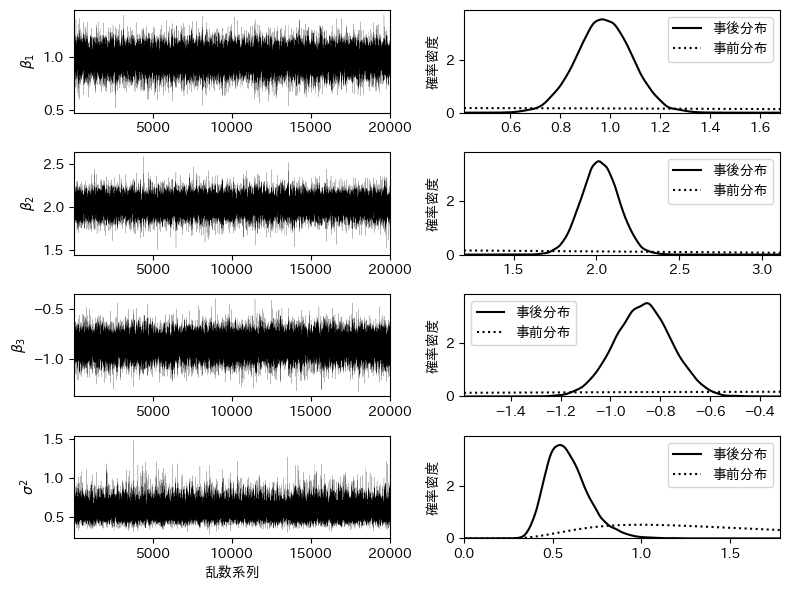

In [15]:
# 4.3: 回帰モデルのベイズ分析（重回帰モデル）
# 回帰モデルからデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0*x1 - x2 + u
X = np.stack((np.ones(n), x1, x2), axis=1)

# 回帰モデルの係数と誤差項の分散の事後分布を設定
k = X.shape[1]
b0 = np.zeros(k)
A0 = 0.2 * np.eye(k)
nu0 = 5.0
lam0 = 7.0
sd0 = np.sqrt(np.diag(la.inv(A0)))
multiple_regression = pm.Model()
with multiple_regression:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0) #事前分布の設定
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k) #事前分布の設定
    y_hat = pm.math.dot(X, b) #尤度の設定
    likelihood = pm.Normal('y', mu=y_hat, sd=pm.math.sqrt(sigma2), observed=y) #尤度の設定

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with multiple_regression:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))

# 事後分布のグラフの作成
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for idx in range(k+1):
    if idx < k:
        mc_trace = trace['b'][:, idx]
        x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=b0[idx], scale=sd0[idx])
        y_label = '$\\beta_{:<d}$'.format(idx+1)
    else:
        mc_trace = trace['sigma2']
        x_min = 0.0
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        y_label = '$\\sigma^2$'
        ax[idx, 0].set_xlabel('乱数系列')
        ax[idx, 1].set_ylabel('パラメータの分布')
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel(y_label)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[idx, 1].plot(x, prior, 'k:', label='事前分布')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
    ax[idx, 1].legend(loc='best')
plt.tight_layout()
plt.show()

### 回帰モデルのベイズ分析（ラプラス分布+半コーシー分布）
データ
$$
    y_i = 1 + 2x + u_i, \ u_i \sim N(0, 0.49), \ i=1,...,50, 
$$

事前分布
$$
    \beta =
    \begin{bmatrix}
        \beta_0 \\ \beta_1
    \end{bmatrix} 
    \sim
    \begin{bmatrix}
        La(\beta_{00}, \tau_{\beta_0}) \\
        La(\beta_{10}, \tau_{\beta_1})
    \end{bmatrix}, \ 
    \sigma \sim Ca^{+}(\tau_{\sigma}), 
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
a      0.994  0.101   0.801    1.181      0.001      0.0   22351.0   14824.0  \
b      2.001  0.104   1.808    2.198      0.001      0.0   24218.0   14658.0   
sigma  0.707  0.074   0.573    0.845      0.000      0.0   23799.0   13137.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0  


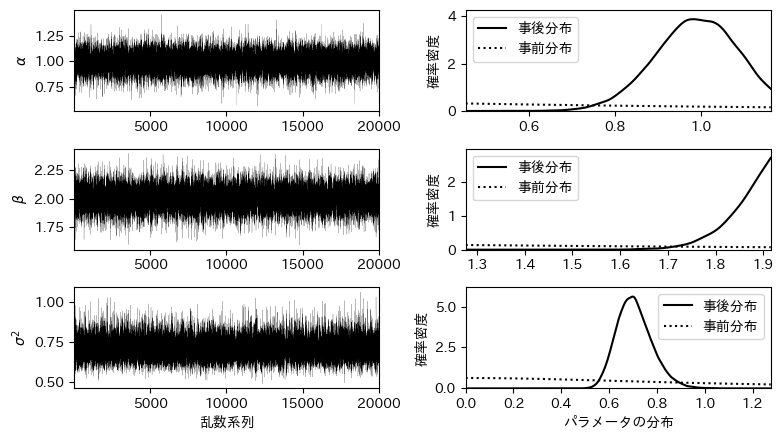

In [17]:
# 4.4: 回帰モデルのベイズ分析（ラプラス分布+半コーシー分布）
# 回帰モデルからデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0*x + u

# 回帰モデルの係数と誤差項の分散の事後分布の設定（ラプラス+半コーシー分布）
b0 = np.zeros(2)
tau_coef = np.ones(2)
tau_sigma = 1.0
regression_laplace_halfcaushy = pm.Model()
with regression_laplace_halfcaushy:
    sigma = pm.HalfCauchy('sigma', beta=tau_sigma)
    a = pm.Laplace('a', mu=b0[0], b=tau_coef[0])
    b = pm.Laplace('b', mu=b0[1], b=tau_coef[1])
    y_hat = a + b*x
    likelihood = pm.Normal('y', mu=y_hat, sd=sigma, observed=y)

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with regression_laplace_halfcaushy:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))

# 事後分布のグラフの作成
k = b0.size
param_names = ['a', 'b', 'sigma']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma^2$']
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for idx in range(k+1):
    mc_trace = trace[param_names[idx]]
    if idx < k:
        x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
        x_max = mc_trace.max() - 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.laplace.pdf(x, loc=b0[idx], scale=tau_coef[idx])
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.halfcauchy.pdf(x, scale=tau_sigma)
        ax[idx, 0].set_xlabel('乱数系列')
        ax[idx, 1].set_xlabel('パラメータの分布')
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel(labels[idx])
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[idx, 1].plot(x, prior, 'k:', label='事前分布')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
    ax[idx, 1].legend(loc='best')
plt.tight_layout()
plt.show()

## 一般化線形モデルのベイズ分析

### ロジット・モデルのベイズ分析
データ
$$
    p(y_i|q_i) = q_i^{y_i} (1-q_i)^{1-y_i}, \
    q_i = \frac{1}{1 + exp{(\frac{1}{2}x_{1i} - \frac{1}{2}x_{2i})}}, \ 
    i = 1, ..., 500, 
$$

事前分布
$$
    \beta = \begin{bmatrix}
        0 \\ 0 \\ 0
    \end{bmatrix}, \ 
    A_o = \begin{bmatrix}
        0.01 && 0 && 0 \\
        0 && 0.01 && 0 \\
        0 && 0 && 0.01
    \end{bmatrix}, 
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
b[0] -0.080  0.096  -0.259    0.100      0.001    0.001   26484.0   15550.0  \
b[1]  0.423  0.098   0.242    0.608      0.001    0.000   23889.0   14849.0   
b[2] -0.487  0.097  -0.664   -0.300      0.001    0.000   26484.0   15026.0   

      r_hat  
b[0]    1.0  
b[1]    1.0  
b[2]    1.0  


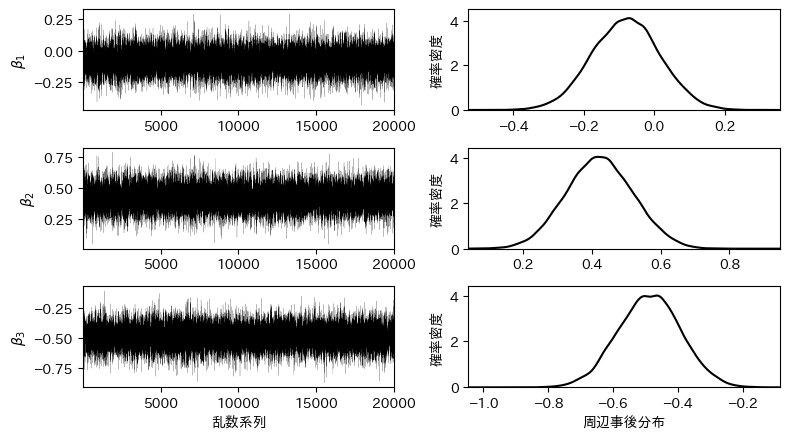

In [21]:
# 4.5: ロジット・モデルのベイズ分析
# ロジット・モデルからのデータ生成
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
q = st.logistic.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q)
X = np.stack((np.ones(n), x1, x2), axis=1)

# ロジット・モデルの係数の事後分布の設定
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
logit_model = pm.Model()
with logit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', logit_p=idx, observed=y)

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with logit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))

# 事後分布のグラフの作成
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for idx in range(k):
    mc_trace = trace['b'][:, idx]
    x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel('$\\beta_{:d}$'.format(idx+1))
    ax[idx, 1].plot(x, posterior, 'k-')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
ax[k-1, 0].set_xlabel('乱数系列')
ax[k-1, 1].set_xlabel('周辺事後分布')
plt.tight_layout()
plt.show()

### プロビット・モデルのベイズ分析
データ
$$
    p(y_i|q_i) = q_i^{y_i} (1-q_i)^{1-y_i}, \
    q_i = \Phi \bigg(\frac{1}{2}x_{1i} - \frac{1}{2}x_{2i} \bigg), \ 
    i = 1, ..., 500, 
$$

事前分布
$$
    \beta = \begin{bmatrix}
        0 \\ 0 \\ 0
    \end{bmatrix}, \ 
    A_o = \begin{bmatrix}
        0.01 && 0 && 0 \\
        0 && 0.01 && 0 \\
        0 && 0 && 0.01
    \end{bmatrix}, 
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.graph.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.graph.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/s1ok69oo/my_study/nakaduma_bayes_2019/venv/lib/python3.10/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/s1ok69oo/my_study/nakaduma_bayes_2019/venv/lib/python3.10/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/Users/s1ok69oo/my_study/nakaduma_bayes_2019/venv/lib/python3.10/site-packages/theano/tensor/opt.py", line 7291, in local_grad_log_erfc_neg
    if not exp_in.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no 

       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
b[0] -0.056  0.061  -0.175    0.053        0.0      0.0   26414.0   14998.0  \
b[1]  0.437  0.064   0.322    0.559        0.0      0.0   25285.0   15947.0   
b[2] -0.469  0.064  -0.585   -0.348        0.0      0.0   24690.0   14248.0   

      r_hat  
b[0]    1.0  
b[1]    1.0  
b[2]    1.0  


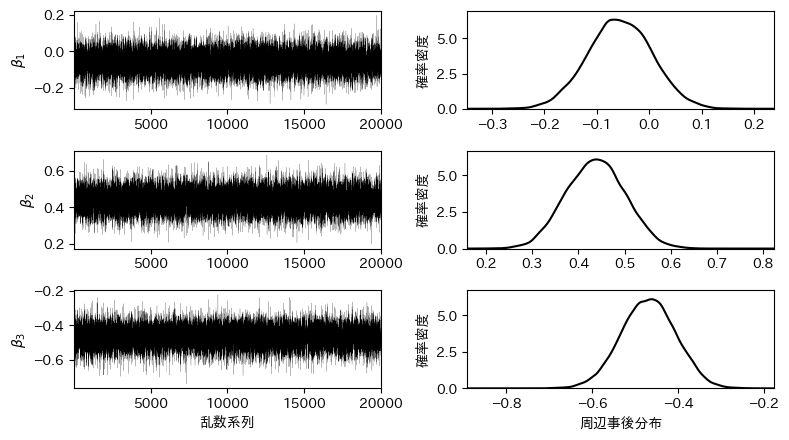

In [23]:
# 4.6: プロビット・モデルのベイズ分析
# 標準正規分布の累積分布関数
def normal_cdf(x):
    return 0.5 * (1.0 + pm.math.erf(x/pm.math.sqrt(2.0)))

# プロビット・モデルからのデータ生成
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
q = st.norm.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q)
X = np.stack((np.ones(n), x1, x2), axis=1)

# プロビット・モデルの係数の事後分布の設定
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
probit_model = pm.Model()
with probit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', p=normal_cdf(idx), observed=y)

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with probit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))

# 事後分布のグラフの作成
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for idx in range(k):
    mc_trace = trace['b'][:, idx]
    x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel('$\\beta_{:d}$'.format(idx+1))
    ax[idx, 1].plot(x, posterior, 'k-')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
ax[k-1, 0].set_xlabel('乱数系列')
ax[k-1, 1].set_xlabel('周辺事後分布')
plt.tight_layout()
plt.show()

### ポアソン回帰モデルのベイズ分析
データ
$$
    p(y_i|\lambda_i) = \frac{\lambda_i^{y_i}e^{-\lambda_i}}{y_i!}, \ 
    \lambda_i = exp \bigg(\frac{1}{2}x_{1i} - \frac{1}{2}x_{2i}\bigg), \ 
    i = 1, ..., 500, 
$$

事前分布
$$
    \beta = \begin{bmatrix}
        0 \\ 0 \\ 0
    \end{bmatrix}, \ 
    A_o = \begin{bmatrix}
        0.01 && 0 && 0 \\
        0 && 0.01 && 0 \\
        0 && 0 && 0.01
    \end{bmatrix}, 
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
b[0]  0.041  0.048  -0.048    0.135        0.0      0.0   12385.0   13742.0  \
b[1]  0.476  0.044   0.394    0.558        0.0      0.0   15262.0   13764.0   
b[2] -0.511  0.042  -0.590   -0.431        0.0      0.0   17445.0   14113.0   

      r_hat  
b[0]    1.0  
b[1]    1.0  
b[2]    1.0  


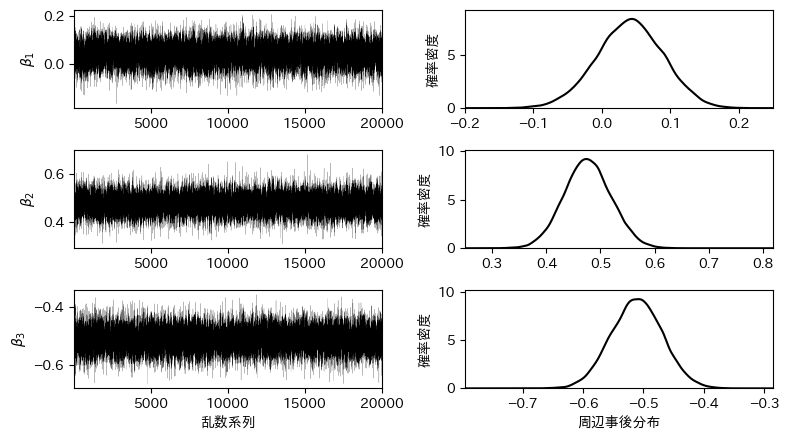

In [24]:
# 4.7: ポアソン回帰モデルのベイズ分析
# プロビット・モデルからのデータ生成
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
lam = np.exp(0.5*x1 - 0.5*x2)
y = st.poisson.rvs(lam)
X = np.stack((np.ones(n), x1, x2), axis=1)

# ポアソン回帰モデルの係数の事後分布の設定
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y)

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with poisson_regression_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))

# 事後分布のグラフの作成
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for idx in range(k):
    mc_trace = trace['b'][:, idx]
    x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel('$\\beta_{:d}$'.format(idx+1))
    ax[idx, 1].plot(x, posterior, 'k-')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
ax[k-1, 0].set_xlabel('乱数系列')
ax[k-1, 1].set_xlabel('周辺事後分布')
plt.tight_layout()
plt.show()